In [74]:
import numpy as np
import torch
from torch.autograd import Variable
from torchvision import transforms, datasets
import torchvision.models.vgg as vgg
from PIL import Image, ImageFile
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
from torchsummary import summary
import time
import glob
import importlib



import data
importlib.reload(data)
import loss_network
importlib.reload(loss_network)
import transformer_network
importlib.reload(transformer_network)

<module 'transformer_network' from 'c:\\Users\\kobil\\Documents\\CSC2503\\Final_Proj\\transformer_network.py'>

In [28]:
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

CUDA = torch.cuda.is_available()

if CUDA:
    device = torch.device("cuda")
    torch.cuda.manual_seed(SEED)
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
else:
    device = torch.device("cpu")
    torch.set_default_tensor_type('torch.FloatTensor')


In [62]:
IMAGE_SIZE = 224
BATCH_SIZE = 4
DATASET_PATH = 'C:\\Users\\kobil\\Documents\\CSC2503\\Final_Proj\\data\\coco_2017'

train_ds = data.get_dataset(DATASET_PATH, IMAGE_SIZE)
train_dl = data.get_dataloader(train_ds, BATCH_SIZE)

In [30]:
loss_net = loss_network.LossNetwork()
loss_net.to(device)

summary(loss_net,(3,IMAGE_SIZE,IMAGE_SIZE))

c:\Users\kobil\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\kobil\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1                          []                        --
|    └─Conv2d: 2-1                       [-1, 64, 224, 224]        1,792
|    └─ReLU: 2-2                         [-1, 64, 224, 224]        --
|    └─Conv2d: 2-3                       [-1, 64, 224, 224]        36,928
|    └─ReLU: 2-4                         [-1, 64, 224, 224]        --
|    └─MaxPool2d: 2-5                    [-1, 64, 112, 112]        --
|    └─Conv2d: 2-6                       [-1, 128, 112, 112]       73,856
|    └─ReLU: 2-7                         [-1, 128, 112, 112]       --
|    └─Conv2d: 2-8                       [-1, 128, 112, 112]       147,584
|    └─ReLU: 2-9                         [-1, 128, 112, 112]       --
|    └─MaxPool2d: 2-10                   [-1, 128, 56, 56]         --
|    └─Conv2d: 2-11                      [-1, 256, 56, 56]         295,168
|    └─ReLU: 2-12                        [-1, 256, 56, 56]      

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1                          []                        --
|    └─Conv2d: 2-1                       [-1, 64, 224, 224]        1,792
|    └─ReLU: 2-2                         [-1, 64, 224, 224]        --
|    └─Conv2d: 2-3                       [-1, 64, 224, 224]        36,928
|    └─ReLU: 2-4                         [-1, 64, 224, 224]        --
|    └─MaxPool2d: 2-5                    [-1, 64, 112, 112]        --
|    └─Conv2d: 2-6                       [-1, 128, 112, 112]       73,856
|    └─ReLU: 2-7                         [-1, 128, 112, 112]       --
|    └─Conv2d: 2-8                       [-1, 128, 112, 112]       147,584
|    └─ReLU: 2-9                         [-1, 128, 112, 112]       --
|    └─MaxPool2d: 2-10                   [-1, 128, 56, 56]         --
|    └─Conv2d: 2-11                      [-1, 256, 56, 56]         295,168
|    └─ReLU: 2-12                        [-1, 256, 56, 56]      

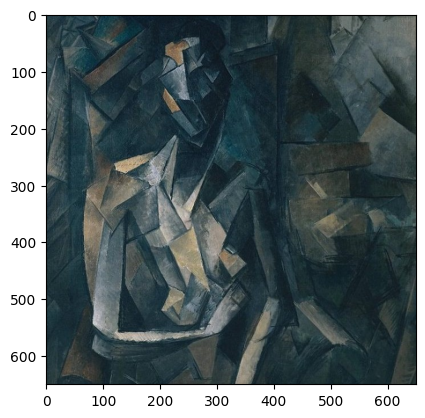

In [31]:
style_img = Image.open('./data/style_images/picasso.jpg').convert('RGB')
plt.imshow(style_img)

In [32]:
with torch.no_grad():
    style_img_tensor = transforms.Compose([
        transforms.Resize(IMAGE_SIZE* 2),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406),#COCO Mean
                            (0.229, 0.224, 0.225))] #COCO STD]
    )(style_img).unsqueeze(0)

    style_img_tensor = style_img_tensor.to(device)


In [33]:
def gram_matrix(y):
    (b, ch, h, w) = y.size()
    features = y.view(b, ch, w * h)
    features_t = features.transpose(1, 2)
    gram = features.bmm(features_t) / (ch * h * w)
    return gram

In [34]:
with torch.no_grad():
    style_loss_features = loss_net(style_img_tensor)
    gram_style = [gram_matrix(y) for y in style_loss_features]

In [35]:
style_loss_features._fields

('relu1', 'relu2', 'relu3', 'relu4', 'relu5')

In [36]:
transformer = transformer_network.TransformerNet()
mse_loss = torch.nn.MSELoss()
transformer.to(device)

TransformerNet(
  (conv1): ConvLayer(
    (reflection_pad): ReflectionPad2d((4, 4, 4, 4))
    (conv2d): Conv2d(3, 32, kernel_size=(9, 9), stride=(1, 1))
  )
  (in1): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (conv2): ConvLayer(
    (reflection_pad): ReflectionPad2d((1, 1, 1, 1))
    (conv2d): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
  )
  (in2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (conv3): ConvLayer(
    (reflection_pad): ReflectionPad2d((1, 1, 1, 1))
    (conv2d): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
  )
  (in3): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (res1): ResidualBlock(
    (conv1): ConvLayer(
      (reflection_pad): ReflectionPad2d((1, 1, 1, 1))
      (conv2d): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    )
    (in1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (

In [47]:
torch.set_default_tensor_type('torch.FloatTensor')
    
def train(steps, base_steps=0):
    transformer.train()
    count = 0
    agg_content_loss = 0.
    agg_style_loss = 0.
    agg_reg_loss = 0.   
    while True:
        for x, _ in train_dl:
            count += 1
            optimizer.zero_grad()
            x = x.to(device)             
            y = transformer(x)            
                        
            with torch.no_grad():
                xc = x.detach()

            features_y = loss_net(y)
            features_xc = loss_net(xc)

            with torch.no_grad():
                f_xc_c = features_xc[2].detach()

            content_loss = CONTENT_WEIGHT * mse_loss(features_y[2], f_xc_c)

            reg_loss = REGULARIZATION * (
                torch.sum(torch.abs(y[:, :, :, :-1] - y[:, :, :, 1:])) + 
                torch.sum(torch.abs(y[:, :, :-1, :] - y[:, :, 1:, :])))

            style_loss = 0.
            for l, weight in enumerate(STYLE_WEIGHTS):
                gram_s = gram_style[l]
                gram_y = gram_matrix(features_y[l])
                style_loss += float(weight) * mse_loss(gram_y, gram_s.expand_as(gram_y))
                
            total_loss = content_loss + style_loss + reg_loss 
            total_loss.backward()
            optimizer.step()

            agg_content_loss += content_loss
            agg_style_loss += style_loss
            agg_reg_loss += reg_loss

            if count % LOG_INTERVAL == 0:
                mesg = "{} [{}/{}] content: {:.2f}  style: {:.2f}  reg: {:.2f} total: {:.6f}".format(
                            time.ctime(), count, steps,
                            agg_content_loss / LOG_INTERVAL,
                            agg_style_loss / LOG_INTERVAL,
                            agg_reg_loss / LOG_INTERVAL,
                            (agg_content_loss + agg_style_loss + 
                             agg_reg_loss ) / LOG_INTERVAL
                        )
                print(mesg)
                agg_content_loss = 0.
                agg_style_loss = 0.
                agg_reg_loss = 0.
                agg_stable_loss = 0.
                transformer.eval()
                y = transformer(x)
                transformer.train()
                
            if count >= steps:
                return

In [38]:

CONTENT_WEIGHT = 1
STYLE_WEIGHTS = np.array([1e-1, 1, 1e1, 5, 1e1]) * 1e4
REGULARIZATION = 1e-6
LOG_INTERVAL = 50

LR = 1e-3
optimizer = torch.optim.Adam(transformer.parameters(), LR)

In [40]:
len(train_dl)

29572

In [54]:
train(1000, 0)

Fri Apr  7 11:12:15 2023 [100/1000] content: 5.17  style: 1.74  reg: 0.09 total: 6.993461
Fri Apr  7 11:12:42 2023 [200/1000] content: 5.03  style: 1.77  reg: 0.08 total: 6.882113
Fri Apr  7 11:13:11 2023 [300/1000] content: 5.11  style: 1.81  reg: 0.09 total: 7.001019
Fri Apr  7 11:13:40 2023 [400/1000] content: 4.90  style: 1.76  reg: 0.08 total: 6.746539
Fri Apr  7 11:14:10 2023 [500/1000] content: 4.91  style: 1.76  reg: 0.09 total: 6.750622
Fri Apr  7 11:14:39 2023 [600/1000] content: 4.82  style: 1.73  reg: 0.08 total: 6.642559
Fri Apr  7 11:15:08 2023 [700/1000] content: 4.72  style: 1.73  reg: 0.08 total: 6.532179
Fri Apr  7 11:15:38 2023 [800/1000] content: 4.92  style: 1.80  reg: 0.08 total: 6.803793
Fri Apr  7 11:16:07 2023 [900/1000] content: 4.94  style: 1.85  reg: 0.08 total: 6.880580
Fri Apr  7 11:16:37 2023 [1000/1000] content: 4.88  style: 1.80  reg: 0.09 total: 6.773017


In [55]:
optimizer = torch.optim.Adam(transformer.parameters(), LR * 0.5)
train(3000, 1000)

Fri Apr  7 11:17:10 2023 [100/3000] content: 5.36  style: 1.81  reg: 0.09 total: 7.256460
Fri Apr  7 11:17:40 2023 [200/3000] content: 5.03  style: 1.81  reg: 0.08 total: 6.920459
Fri Apr  7 11:18:10 2023 [300/3000] content: 4.90  style: 1.79  reg: 0.09 total: 6.773588
Fri Apr  7 11:18:39 2023 [400/3000] content: 4.82  style: 1.75  reg: 0.09 total: 6.651712
Fri Apr  7 11:19:09 2023 [500/3000] content: 4.96  style: 1.79  reg: 0.08 total: 6.839999
Fri Apr  7 11:19:39 2023 [600/3000] content: 5.19  style: 1.89  reg: 0.09 total: 7.161014
Fri Apr  7 11:20:09 2023 [700/3000] content: 4.77  style: 1.83  reg: 0.09 total: 6.688594
Fri Apr  7 11:20:39 2023 [800/3000] content: 4.73  style: 1.86  reg: 0.09 total: 6.686132
Fri Apr  7 11:21:08 2023 [900/3000] content: 4.67  style: 1.86  reg: 0.09 total: 6.619448
Fri Apr  7 11:21:38 2023 [1000/3000] content: 4.56  style: 1.84  reg: 0.09 total: 6.482714
Fri Apr  7 11:22:08 2023 [1100/3000] content: 4.57  style: 1.86  reg: 0.09 total: 6.520088
Fri Apr 

In [56]:
save_model_path = "models/picaso_4000_unstable_vgg19.pth"
torch.save(transformer.state_dict(), save_model_path)

In [57]:

LOG_INTERVAL = 100
optimizer = torch.optim.Adam(transformer.parameters(), LR * 0.1)
train(6000, 4000)

Fri Apr  7 11:32:01 2023 [100/6000] content: 4.06  style: 1.94  reg: 0.09 total: 6.086592
Fri Apr  7 11:32:30 2023 [200/6000] content: 3.96  style: 1.94  reg: 0.09 total: 5.997711
Fri Apr  7 11:32:58 2023 [300/6000] content: 4.12  style: 2.02  reg: 0.09 total: 6.229236
Fri Apr  7 11:33:26 2023 [400/6000] content: 4.06  style: 1.97  reg: 0.09 total: 6.127263
Fri Apr  7 11:33:54 2023 [500/6000] content: 4.05  style: 1.98  reg: 0.09 total: 6.123987
Fri Apr  7 11:34:22 2023 [600/6000] content: 4.03  style: 2.02  reg: 0.09 total: 6.137374
Fri Apr  7 11:34:50 2023 [700/6000] content: 3.91  style: 1.97  reg: 0.09 total: 5.971008
Fri Apr  7 11:35:19 2023 [800/6000] content: 3.99  style: 1.99  reg: 0.09 total: 6.067310
Fri Apr  7 11:35:47 2023 [900/6000] content: 3.76  style: 1.88  reg: 0.09 total: 5.730065
Fri Apr  7 11:36:15 2023 [1000/6000] content: 3.94  style: 2.01  reg: 0.09 total: 6.050847
Fri Apr  7 11:36:43 2023 [1100/6000] content: 3.98  style: 1.99  reg: 0.09 total: 6.055572
Fri Apr 

In [58]:
save_model_path = "models/picaso_10000_unstable_vgg19.pth"
torch.save(transformer.state_dict(), save_model_path)

In [63]:
fnames = glob.glob(DATASET_PATH + r"/*/*")
len(fnames)

118287

In [64]:
transformer = transformer.eval()

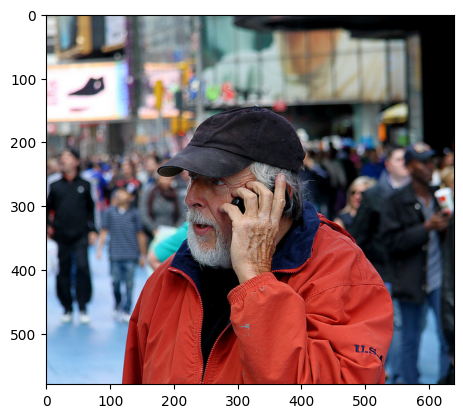

In [150]:
img = Image.open(fnames[70]).convert('RGB')
plt.imshow(img)
img_tensor = transforms.Compose([
        transforms.Resize(IMAGE_SIZE* 2),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406),#COCO Mean
                            (0.229, 0.224, 0.225))] #COCO STD]
    )(img).unsqueeze(0)
img_tensor = img_tensor.cuda()


In [151]:
def recover_image(img):
    return (
        (
            img *
            np.array([0.229, 0.224, 0.225]).reshape((1, 3, 1, 1)) +
            np.array([0.485, 0.456, 0.406]).reshape((1, 3, 1, 1))
        ).transpose(0, 2, 3, 1) *
        255.
    ).clip(0, 255).astype(np.uint8)

In [152]:

img_output = transformer(img_tensor)

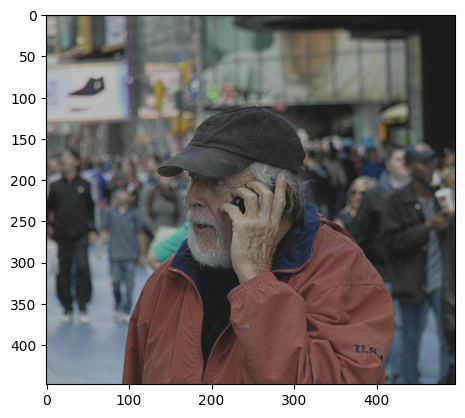

In [153]:
img_output = img_output.cpu()
img_output = img_output.detach().numpy()
#img_output = np.reshape(img_output, (3,448,448))
#img_output = img_output * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
#img_output = np.transpose(img_output, (1,2,0))
img_output = recover_image(img_output)
img_output = np.reshape(img_output, (448, 496, 3))
plt.imshow(img_output)